In [1]:
import pandas as pd
import pyterrier as pt
import matplotlib.pyplot as plt
import seaborn as sns
# read csvs without header, column names are qid, sep, uuid, score
if not pt.started():
    pt.init()
qrels = pt.io.read_qrels("assessments/qrels.txt") # type: ignore
qcred = pt.io.read_qrels("assessments/qcredibility.txt") # type: ignore
qread = pt.io.read_qrels("assessments/qreadability.txt") # type: ignore


PyTerrier 0.9.2 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_topics(path, clean_query=False):
    with open(path) as f:
        root = ET.fromstring(f.read())
    topic_dict = {}
    for topic in root.findall("topic"):
        topic_id = topic.findtext("id")
        topic_query = topic.findtext("query")
        if topic_id and topic_query:
            topic_dict[topic_id] = topic_query.strip()
    topics = pd.DataFrame(topic_dict.items(), columns=["qid", "query"]) 
    if clean_query:
        topics["query"] = topics["query"].str.lower().replace(r'\W+', ' ', regex=True)
    return topics

In [3]:
plot_folder = "plots/"

In [4]:
all_queries_df = load_topics("./topics/topics.txt", clean_query=False)

ValueError: Could not interpret input 'is_question'

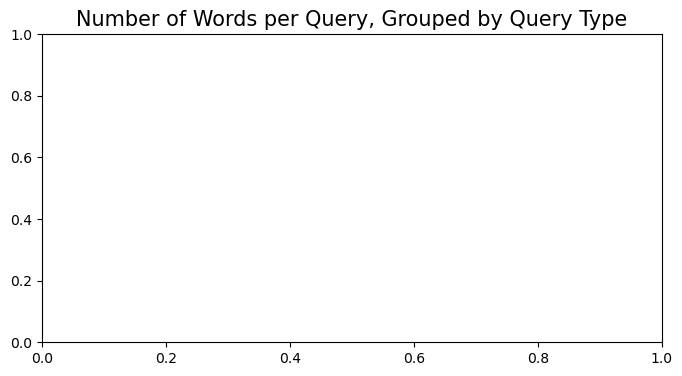

In [ ]:
all_passages = pd.read_csv("Webdoc/data/txt_min_length_50.tsv", sep="\t")

In [ ]:
# Add word count column
all_passages["num_words"] = all_passages["text"].str.split().str.len()

In [ ]:
all_passages["num_words"].describe()

count     6692.000000
mean      2901.171698
std       5062.994769
min         18.000000
25%        788.000000
50%       1354.000000
75%       2881.000000
max      79920.000000
Name: num_words, dtype: float64

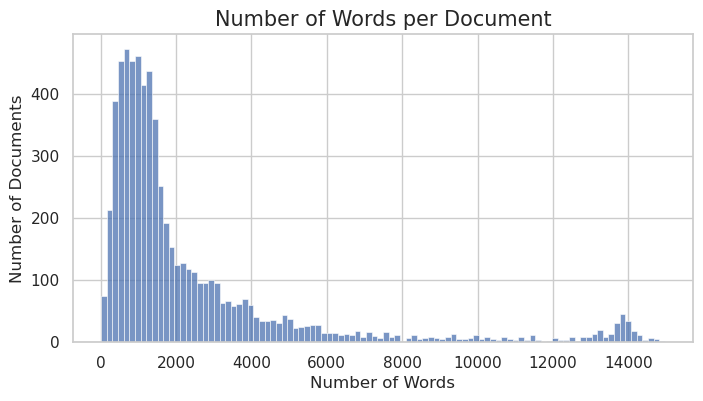

In [ ]:
# plot word count distribution
# exclude outliers with more than N words
plt.figure(figsize=(8, 4))
plt.title("Number of Words per Document", fontsize=15)
sns.histplot(all_passages[all_passages["num_words"] < 15000]["num_words"], bins=100)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.savefig(plot_folder + "num_words_per_passage.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# How many outlies are there?
all_passages[all_passages["num_words"] > 15000].shape[0]/all_passages.shape[0]


0.017931858936043037

In [ ]:
# drop all qrels, qcred, qread that are not in all_passages docid
qrels = qrels[qrels["docno"].isin(all_passages["docid"])]
qcred = qcred[qcred["docno"].isin(all_passages["docid"])]
qread = qread[qread["docno"].isin(all_passages["docid"])]

In [ ]:
# merge qrels, qcred, qread 
qrels_cred = pd.merge(qrels, qcred, on=["qid", "docno"], suffixes=("_rel", "_cred"))
qrels_cred_read = pd.merge(qrels_cred, qread, on=["qid", "docno"])
# rename columns
qrels_cred_read.columns = ["qid", "docno", "rel", "cred", "read"]
qrels_cred_read.to_csv("assessments/qrels_cred_read.txt", sep=" ", index=False)

In [ ]:
qrels_cred_read.describe()

,rel,cred,read
count,8902.000000,8902.000000,8902.000000
mean,0.767693,1.543698,1.396652
std,0.813850,0.733773,0.712324
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000
75%,1.000000,2.000000,2.000000
max,2.000000,3.000000,2.000000


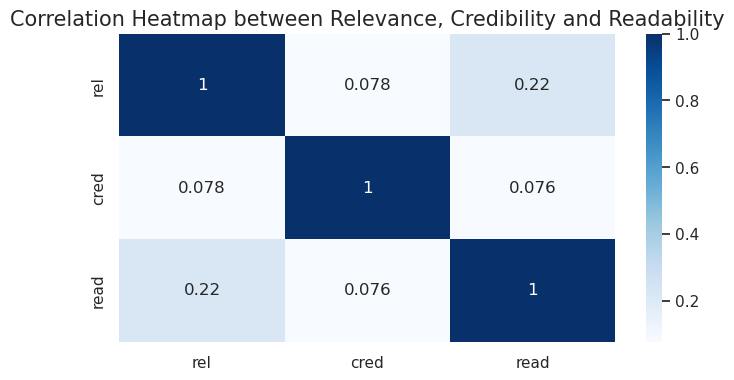

In [ ]:
# Correlation Heatmap between Relevance, Credibility and Readability
plt.figure(figsize=(8, 4))
plt.title("Correlation Heatmap between Relevance, Credibility and Readability", fontsize=15)
sns.heatmap(qrels_cred_read[["rel", "cred", "read"]].corr(), annot=True, cmap="Blues")
plt.savefig(plot_folder + "correlation_heatmap.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# for all qids, calculate the average rel, cred, read, add new column with number of docs per qid

qrels_cred_read["num_docs"] = qrels_cred_read.groupby("qid")["qid"].transform("count")
qrels_cred_read["avg_rel"] = qrels_cred_read.groupby("qid")["rel"].transform("mean")
qrels_cred_read["avg_cred"] = qrels_cred_read.groupby("qid")["cred"].transform("mean")
qrels_cred_read["avg_read"] = qrels_cred_read.groupby("qid")["read"].transform("mean")

qrels_cred_read.head()

,qid,docno,rel,cred,read,num_docs,avg_rel,avg_cred,avg_read
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2,2,2,244,1.065574,1.17623,1.586066
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1,1,1,244,1.065574,1.17623,1.586066
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2,2,2,244,1.065574,1.17623,1.586066
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0,2,2,244,1.065574,1.17623,1.586066
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1,2,2,244,1.065574,1.17623,1.586066


In [ ]:
assesed_docs_df = pd.read_csv("Webdoc/data/assessed_docs.csv")
assesed_docs_df

,Unnamed: 0,url,timestamp,charset,domain,uri,filename,offset,length,digest
0,743139,https://jhu.pure.elsevier.com/en/publications/...,20210116034145,UTF-8,jhu.pure.elsevier.com,a6195d99-f7d7-43ec-907c-435cb7a62ee7,crawl-data/CC-MAIN-2021-04/segments/1610703499...,405618795,9181,PD4OJTGSKE66SPZVH7Q66C7EGTZAD4TO
1,96552,https://www.medpagetoday.com/neurology/alzheim...,20210117033815,UTF-8,www.medpagetoday.com,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,crawl-data/CC-MAIN-2021-04/segments/1610703509...,880993939,19659,LLEMLJ24KJV2DM5FGPQPYMDAWVA3WKZQ
2,961415,https://www.omicsonline.org/journal-health-car...,20210124192047,UTF-8,www.omicsonline.org,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,crawl-data/CC-MAIN-2021-04/segments/1610703550...,917958124,18815,LXAYVR3PTS7SUHXFUB4DOQKCEX4FATIJ
3,266966,https://www.nap.edu/read/1222/chapter/33,20210123090508,UTF-8,www.nap.edu,22990a4b-6a9f-4e00-9e72-aef0fbee202b,crawl-data/CC-MAIN-2021-04/segments/1610703536...,920962674,152297,3KWCY54WZJZ4GG4PABZRP2DF7KOZKJ2V
4,2875493,https://www.verywellmind.com/maybe-its-not-dep...,20210128062202,UTF-8,www.verywellmind.com,fd6ddab2-e4d9-4151-9972-256f5be6eb21,crawl-data/CC-MAIN-2021-04/segments/1610704835...,1041034535,50300,OSNY3LOK2AGPNRGM4RPDO27WD3IB5YG5
...,...,...,...,...,...,...,...,...,...,...
6759,33409,https://quizlet.com/63316052/mm-23-flash-cards/,20210121203122,UTF-8,quizlet.com,4bcdbe2c-c65c-4ccf-b09d-607d29c6ff5b,crawl-data/CC-MAIN-2021-04/segments/1610703527...,522563191,72658,7RIHJ6BHE7KWZG43CNASGDD4TFDSX3HM
6760,935711,https://www.uspharmacist.com/article/what-phar...,20210126062309,UTF-8,uspharmacist.com,c3597cec-764e-4d79-b738-209363b7b9a5,crawl-data/CC-MAIN-2021-04/segments/1610704798...,1026135999,17893,TTQCUA6HR7HA7XBU46KUWYPVM7XN5RQU
6761,672158,https://quizlet.com/339743793/skin-flash-cards/,20210122013153,UTF-8,quizlet.com,ac57ae51-3d04-483b-a56f-6379f12f41e8,crawl-data/CC-MAIN-2021-04/segments/1610703528...,523024819,57052,XVRQF6FYSEVTCAFJMD2THSVI5LBUPOLH
6762,2855240,https://www.mayoclinic.org/diseases-conditions...,20210119221556,UTF-8,www.mayoclinic.org,ff31591b-0f36-460f-932b-f57422d0ee62,crawl-data/CC-MAIN-2021-04/segments/1610703519...,887810494,7135,ILVPQ6FWRJVSN2WGOUC7C7OZ3CAGF2UB


In [ ]:
# number of unique domains
number_unique_domains = assesed_docs_df["domain"].nunique()
# add domain column to qrels_cred_read
qrels_cred_read = pd.merge(qrels_cred_read, assesed_docs_df[["uri", "domain"]], left_on="docno", right_on="uri")
# drop uri column
qrels_cred_read = qrels_cred_read.drop(columns=["uri"])


In [ ]:
qrels_cred_read.describe()

,rel,cred,read
count,8902.000000,8902.000000,8902.000000
mean,0.767693,1.543698,1.396652
std,0.813850,0.733773,0.712324
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,2.000000,2.000000
75%,1.000000,2.000000,2.000000
max,2.000000,3.000000,2.000000


In [ ]:
# domains ordered by number of docs
popular_domains = qrels_cred_read.groupby("domain")["domain"].count().sort_values(ascending=False)
# print domain names
print(popular_domains.head(10))

domain
www.healthline.com           883
www.nationalmssociety.org    861
www.ms.org.au                645
jhu.pure.elsevier.com        250
www.msif.org                 247
my.clevelandclinic.org       231
www.emedicinehealth.com      190
www.news-medical.net         179
www.psychologytoday.com      162
www.mymsaa.org               159
Name: domain, dtype: int64


In [ ]:
# number of domains that show up rarely
print(popular_domains[popular_domains <= 10].count())

133


In [ ]:
print(popular_domains[popular_domains == 1].count())

44


In [ ]:
# unique domains
print(popular_domains.describe())

count    234.000000
mean      38.042735
std       99.468492
min        1.000000
25%        2.000000
50%        7.000000
75%       26.000000
max      883.000000
Name: domain, dtype: float64


In [ ]:
qrels_cred_read.head()

,qid,docno,rel,cred,read,num_docs,avg_rel,avg_cred,avg_read,uri,domain
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2,2,2,244,1.065574,1.176230,1.586066,a6195d99-f7d7-43ec-907c-435cb7a62ee7,jhu.pure.elsevier.com
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1,1,1,244,1.065574,1.176230,1.586066,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,www.medpagetoday.com
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2,2,2,244,1.065574,1.176230,1.586066,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,www.omicsonline.org
3,52,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,0,2,0,189,0.724868,1.783069,1.095238,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,www.omicsonline.org
4,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0,2,2,244,1.065574,1.176230,1.586066,22990a4b-6a9f-4e00-9e72-aef0fbee202b,www.nap.edu


In [ ]:
# get average rel, cred, read per qid
query_stats = qrels_cred_read.groupby("qid", as_index=False).agg({"avg_rel": "mean", "avg_cred": "mean", "avg_read": "mean", "num_docs": "mean"})
# get stats for 
query_stats.describe()

In [ ]:
from scipy.stats import kendalltau
# for each query with query id qid, get list of documents with relevance score
def get_relevant_docs(qs, qid):
    qs = qs[qs["qid"] == qid][["docno", "label"]].values.tolist()
    # sort by relevance score descending, then by docno ascending
    qs = sorted(qs, key=lambda x: (-x[1], x[0]))
    return [x[0] for x in qs]
    
relevant_docs = [] 
for qid in all_queries_df["qid"]:
    doc_dict = {}
    doc_dict["qid"] = qid
    doc_dict["relevance"] = get_relevant_docs(qrels, qid)
    doc_dict["credibility"] = get_relevant_docs(qcred, qid)
    doc_dict["readability"] = get_relevant_docs(qread, qid)
    # calculate kendale's tau for relevance and credibility and relevance and readability
    doc_dict["rel_cred_tau"] = kendalltau(doc_dict["relevance"], doc_dict["credibility"])
    doc_dict["rel_read_tau"] = kendalltau(doc_dict["relevance"], doc_dict["readability"])
    doc_dict["cred_read_tau"] = kendalltau(doc_dict["credibility"], doc_dict["readability"])
    relevant_docs.append(doc_dict)


In [ ]:
# get the average kendall's tau for relevance and credibility and relevance and readability
rel_cred_tau = [x["rel_cred_tau"][0] for x in relevant_docs]
rel_read_tau = [x["rel_read_tau"][0] for x in relevant_docs]
cred_read_tau = [x["cred_read_tau"][0] for x in relevant_docs]
# drop nan values
rel_cred_tau = [x for x in rel_cred_tau if str(x) != 'nan']
rel_read_tau = [x for x in rel_read_tau if str(x) != 'nan']
cred_read_tau = [x for x in cred_read_tau if str(x) != 'nan']

def calculate_relevant_statistics(tau_list):
    mean = sum(tau_list) / len(tau_list)
    std = (sum([(x - mean)**2 for x in tau_list]) / len(tau_list))**0.5
    return mean, std

credibility_mean, credibility_std = calculate_relevant_statistics(rel_cred_tau)
readability_mean, readability_std = calculate_relevant_statistics(rel_read_tau)
credibility_readability_mean, credibility_readability_std = calculate_relevant_statistics(cred_read_tau)

print("Kendall's Tau Statistics")
print(f"relevance credibility mean: {credibility_mean}, std: {credibility_std}")
print(f"relevance readability mean: {readability_mean}, std: {readability_std}")
print(f"credibility readability mean: {credibility_readability_mean}, std: {credibility_readability_std}")


In [ ]:
# new dataframe with qid, number_of_relevant_docs, number_of_credible_docs, number_of_readable_docs, and tau values
relevant_docs_df = pd.DataFrame(relevant_docs)
relevant_docs_df["number_of_docs"] = relevant_docs_df["relevance"].apply(lambda x: len(x))
relevant_docs_df["rel_cred_tau"] = relevant_docs_df["rel_cred_tau"].apply(lambda x: x[0])
relevant_docs_df["rel_read_tau"] = relevant_docs_df["rel_read_tau"].apply(lambda x: x[0])
relevant_docs_df["cred_read_tau"] = relevant_docs_df["cred_read_tau"].apply(lambda x: x[0])
# remove relevance, credibility, readability columns
relevant_docs_df = relevant_docs_df.drop(columns=["relevance", "credibility", "readability"])
# sort by number of docs descending
relevant_docs_df = relevant_docs_df.sort_values(by=["number_of_docs"], ascending=True)
# drop rows with nan values
relevant_docs_df = relevant_docs_df.dropna()
# get rows with qids in 1, 77, 108, 132, 133
relevant_docs_df[relevant_docs_df["qid"].isin(["1", "77", "108", "132", "133"])]

In [ ]:
# other statistics that could be interesting to look at:
# number of relevant docs that are credible
# number of relevant docs that are readable



In [ ]:
# check for relation between number of docs and tau values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# include line of best fit
def plot_tau_vs_number_of_docs(tau_list, number_of_docs_list, tau_name):
    plt.figure(figsize=(10, 10))
    sns.regplot(x=number_of_docs_list, y=tau_list)
    plt.scatter(number_of_docs_list, tau_list)
    plt.xlabel("Number of Documents")
    plt.ylabel(tau_name)
    plt.title(f"{tau_name} vs Number of Documents")
    plt.show()

plot_tau_vs_number_of_docs(relevant_docs_df["rel_cred_tau"], relevant_docs_df["number_of_docs"], "Relevance Credibility Tau")
plot_tau_vs_number_of_docs(relevant_docs_df["rel_read_tau"], relevant_docs_df["number_of_docs"], "Relevance Readability Tau")
plot_tau_vs_number_of_docs(relevant_docs_df["cred_read_tau"], relevant_docs_df["number_of_docs"], "Credibility Readability Tau")

In [ ]:
# get query text from queries dataframe
def get_query_text(qid):
    return all_queries_df[all_queries_df["qid"] == qid]["query"].values[0]

get_query_text("1")

In [ ]:


# print out the queries with the highest and lowest tau values
def print_queries_with_highest_and_lowest_tau(tau_list, number_of_docs_list, tau_name, queries, n):
    # sort by tau value
    tau_list, number_of_docs_list, queries = zip(*sorted(zip(tau_list, number_of_docs_list, queries), reverse=True))
    print(f"Queries with highest {tau_name}")
    for i in range(n):
        print(f"Query {queries[i]}: {tau_name} {tau_list[i]}, number of docs {number_of_docs_list[i]}")
        print(f"Query text: {get_query_text(queries[i])}")
        print()
    print("*"*50)
    print(f"Queries with lowest {tau_name}")
    for i in range(n):
        print(f"Query {queries[-i-1]}: {tau_name} {tau_list[-i-1]}, number of docs {number_of_docs_list[-i-1]}")
        print(f"Query text: {get_query_text(queries[-i-1])}")
        print() 

print_queries_with_highest_and_lowest_tau(relevant_docs_df["rel_cred_tau"], relevant_docs_df["number_of_docs"], "Relevance Credibility Tau", relevant_docs_df["qid"], 5)

In [ ]:
passages_with_qrels = pd.merge(all_passages, qrels, left_on="docid", right_on="docno")

In [ ]:
passages_with_qread = pd.merge(all_passages, qread, left_on="docid", right_on="docno")

In [ ]:
passages_with_qcred = pd.merge(all_passages, qcred, left_on="docid", right_on="docno")

In [ ]:
passages_with_qcred.head()

In [ ]:
# merge qrels, qcred, qread to one dataframe with columns qid, uuid, qrel, qcred, qread
qmerge = qrels.merge(qcred, on=["qid", "docno"], how="left")
qmerge = qmerge.merge(qread, on=["qid", "docno"], how="left")
qmerge = qmerge.rename(columns={"docno": "uuid", "label_x": "qrel", "label_y": "qcred", "label": "qread"})

In [ ]:
# filter qmerge for uuids which are in all_passages
qmerge = qmerge[qmerge.uuid.isin(all_passages.docid)]

In [ ]:
qmerge.head()

In [ ]:
# get number of unique uuids
print(len(qmerge.uuid.unique()))
# get all duplicate uuids and print them, incuding the number of duplicates and the values in the columns as list
duplicates = qmerge[qmerge.uuid.duplicated(keep=False)].groupby("uuid").agg({"uuid": "count", "qrel": list, "qcred": list, "qread": list, "qid": list}).rename(columns={"uuid": "count"}).sort_values("count", ascending=False)

# visualize duplicates
duplicates.head()
print(len(duplicates))

print("total number of uuids ", len(qmerge))

In [ ]:
duplicates.head()

In [ ]:
# plot first duplicate uuid and compare the values of qrel, qcred, qread using a seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

dup = duplicates.iloc[1]
# expand the lists in the columns to columns
dup = dup.apply(pd.Series).T
dup

In [ ]:
# add column to duplicates with cred_diff and read_diff, containing the maximum difference between the values in the list
duplicates["cred_diff"] = duplicates["qcred"].apply(lambda x: max(x) - min(x))
duplicates["read_diff"] = duplicates["qread"].apply(lambda x: max(x) - min(x))
# get duplicates with cred_diff == 0 and read_diff == 0
duplicates[(duplicates["cred_diff"] == 0) & (duplicates["read_diff"] == 0)]

In [ ]:
# get duplicates with diffs higher than 0 and calculate the mean of the diffs
duplicates[(duplicates["cred_diff"] > 0) & (duplicates["read_diff"] > 0)].mean()

In [ ]:
# generate separate heatmap for qrel 0,1 and 2, showing qcred and qread on the x and y axis. Usa a nice color scheme and annotate the cells with the number of passages in each cell.

import seaborn as sns
import matplotlib.pyplot as plt

qmerge["qrel"] = qmerge["qrel"].astype(int)
qmerge["qcred"] = qmerge["qcred"].astype(int)
qmerge["qread"] = qmerge["qread"].astype(int)

# generate 3 heatmaps next to each other
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# heatmap for qrels. colormap should have same intensity for all qrels
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = qmerge.groupby(["qrel", "qcred", "qread"]).size().min()
vmax = qmerge.groupby(["qrel", "qcred", "qread"]).size().max()
for rel in [0,1,2]:
    qrel = qmerge[qmerge.qrel == rel]
    sns.heatmap(qrel.groupby(["qcred", "qread"]).size().unstack(), annot=True, fmt="d", ax=axes[rel], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[rel].set_title(f"qrel {rel}" + "\n Total: " + str(len(qrel)))


In [ ]:
def get_text_from_uuid(uuid):
    return all_passages[all_passages.docid == uuid].text.values[0]

def get_query_from_qid(qid):
    return all_queries_df[all_queries_df.qid == qid]['query'].values[0]

get_text_from_uuid("fc1fd012-c7d3-4ed2-ae3b-ed795426759c")

In [ ]:
for qid in list(dup['qid'].values):
    print(get_query_from_qid(str(qid)))

In [ ]:
# new df with cols qid, qrel_0, qrel_1, qrel_2, qcred_0, qcred_1, qcred_2, qread_0, qread_1, qread_2
# uuid is dropped, qrel_0 contains the number of uuids with qrel=0 for each qid
qagg = qmerge.groupby(["qid"]).agg({"qrel": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "qcred": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum(), lambda x: (x==3).sum()],
                                        "qread": [lambda x: (x==0).sum(), lambda x: (x==1).sum(), lambda x: (x==2).sum()],
                                        "uuid": "count"})
qagg.columns = ["qrel_0", "qrel_1", "qrel_2", "qcred_0", "qcred_1", "qcred_2", "qcred_3", "qread_0", "qread_1", "qread_2", "uuid_count"]
qagg = qagg.reset_index()
# order dataframe by qid, qid as integer
qagg = qagg.sort_values(by=["qid"], key=lambda x: x.astype(int))

NameError: name 'qagg' is not defined

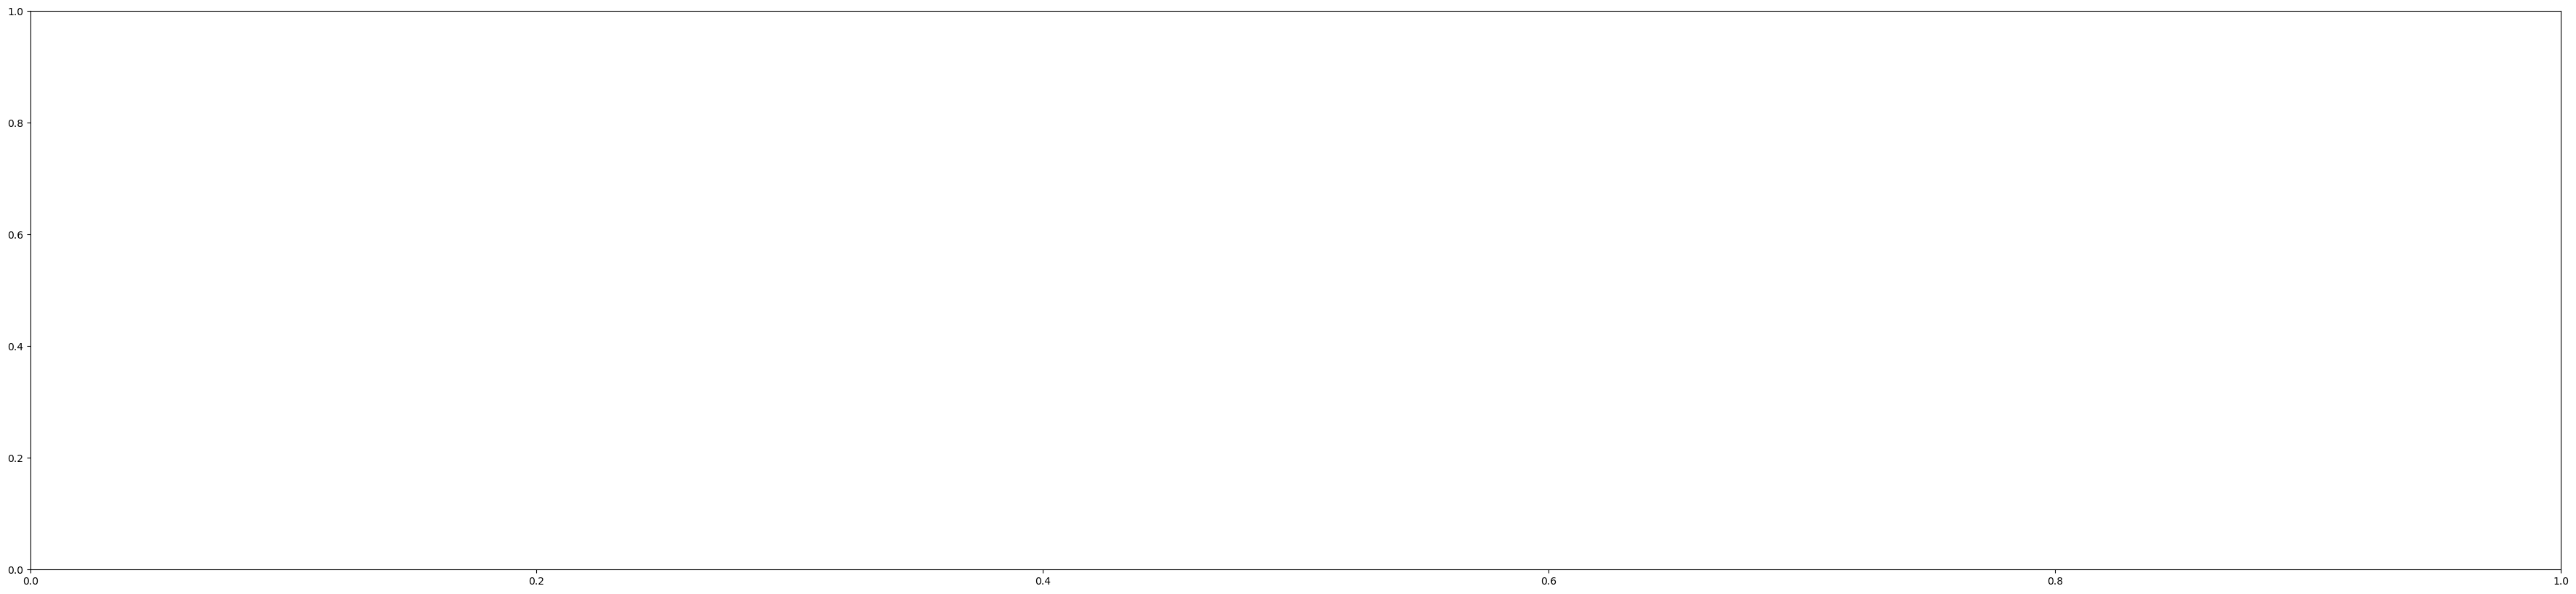

In [6]:
# visualize the table as a bar chart. qrels, qcred, qread are plotted in separate bars, to in total 3 bars per qid.
# The different values (qrel_0, qrel_1, qrel2) of qrels, qcred, qread are stacked on top of each other.
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams['figure.figsize'] = [45, 10]

fig, ax = plt.subplots()
# set width of bar
width = 0.25

# 4 colors blue green red yellow
colors = ["#1f77b4", "#2ca02c", "#d62728", "#ff7f0e"]

bottom = np.zeros(50)

weight_counts_qrels = {
    "qrel0": qagg.qrel_0,
    "qrel1": qagg.qrel_1,
    "qrel2": qagg.qrel_2
}

weight_counts_qcred = {
    "qcred0": qagg.qcred_0,
    "qcred1": qagg.qcred_1,
    "qcred2": qagg.qcred_2,
    "qcred3": qagg.qcred_3
}
weight_counts_qread = {
    "qread0": qagg.qread_0,
    "qread1": qagg.qread_1,
    "qread2": qagg.qread_2
}

all_weight_counts = [weight_counts_qrels, weight_counts_qcred, weight_counts_qread]

x = np.arange(50)
for idx, all_weight in enumerate(all_weight_counts):
    bottom = np.zeros(50)
    color_index = 0
    for boolean, weight_count in all_weight.items():
        p = ax.bar(x + idx*0.25, weight_count, width, label=boolean, bottom=bottom, color=colors[color_index])
        bottom += weight_count
        color_index += 1

# Add some text for labels, title and custom x-axis tick labels, etc.

plt.xlabel('qid')
plt.ylabel('count')
plt.title('Counts of qrels, qcred, qread per qid')
plt.xticks(x + width, qagg.qid)
# Create legend & Show graphic
plt.legend()
plt.show()
